# Exploring TensorFlow Probability STS Forecsating

In this notebook we want to explore the [Structural Time Series (STS) Module](https://www.tensorflow.org/probability/api_docs/python/tfp/sts) of [TensorFlow Probability](https://www.tensorflow.org/probability/). We are going to follow closely the [use cases](https://medium.com/tensorflow/structural-time-series-modeling-in-tensorflow-probability-344edac24083) presented in their blog. 

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
print(tf.__version__)
print(tfp.__version__)

2.1.0
0.8.0-rc0


## Generate Data

We generate are going to consider daily data on the range `2018-01-01` to `2020-12-31`.

In [3]:
# Create dataframe with a date range (4 years).
df = pd.DataFrame(
    data={'date': pd.date_range(start='2017-01-01', end='2020-12-31', freq='D')}
)

n = df.shape[0]

In [4]:
# Start with Gaussian noise. 
df['y'] = np.random.normal(loc=0.0, scale=0.5, size=n)

In [5]:
# External regressor:
df['x'] = np.random.uniform(low=0.0, high=1.0, size=n)
df['x'] = df['x'].apply(lambda x: x if abs(x) > 0.95 else 0.0)

df['y'] = df['y'] + 5*df['x']

In [6]:
np.random.seed(seed=42)

# Seasonal variables:
df['day_of_month'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['daysinmonth'] = df['date'].dt.daysinmonth


df['y'] = df['y'] \
    + np.power(df.index.values, 1/3) \
    + 2*np.cos(2*np.pi*df['month']/12) + 0.5*np.sin(2*np.pi*df['month']/12)\
    + 1.5*np.cos(2*np.pi*df['day_of_week']/7) \
    + 2*np.sin(2*np.pi*df['day_of_month']/ df['daysinmonth'])

df['y'] = df['y'].fillna(method='backfill').astype(np.float32)

df.head(10)

,date,y,x,day_of_month,month,day_of_week,daysinmonth
0,2017-01-01,3.574185,0.0,1,1,6,31
1,2017-01-02,5.791398,0.0,2,1,0,31
2,2017-01-03,5.666129,0.0,3,1,1,31
3,2017-01-04,4.820653,0.0,4,1,2,31
4,2017-01-05,3.941547,0.0,5,1,3,31
5,2017-01-06,4.670163,0.0,6,1,4,31
6,2017-01-07,5.652978,0.0,7,1,5,31
7,2017-01-08,7.224062,0.0,8,1,6,31
8,2017-01-09,7.658290,0.0,9,1,0,31
9,2017-01-10,7.123433,0.0,10,1,1,31


Let us plot the generated data:

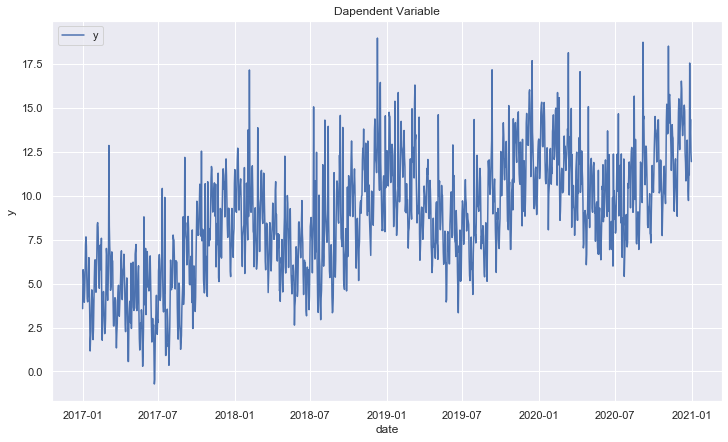

In [7]:
plt.rcParams['figure.figsize'] = [12, 7]

fig, ax = plt.subplots()
sns.lineplot(x='date', y='y', label='y', data=df, ax=ax)
ax.legend(loc='upper left')
ax.set(title='Dapendent Variable');

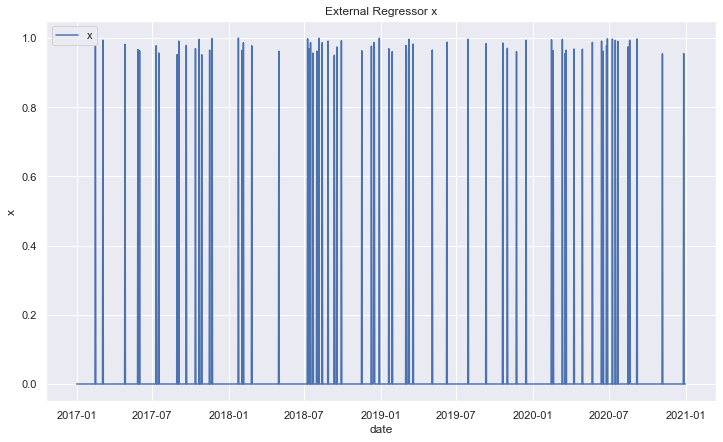

In [8]:
plt.rcParams['figure.figsize'] = [12, 7]

fig, ax = plt.subplots()
sns.lineplot(x='date', y='x', label='x', data=df, ax=ax)
ax.legend(loc='upper left')
ax.set(title='External Regressor x');

## Train - Test Split

We assume we have data until `2020-06-30` and we will predict six months ahead. We assume we have acces to the `x` variable in advance (e.g. media spend plan). 

In [9]:
threshold_date = pd.to_datetime('2020-07-01')
mask = df['date'] < threshold_date

df_train = df[mask]
df_test = df[~ mask]

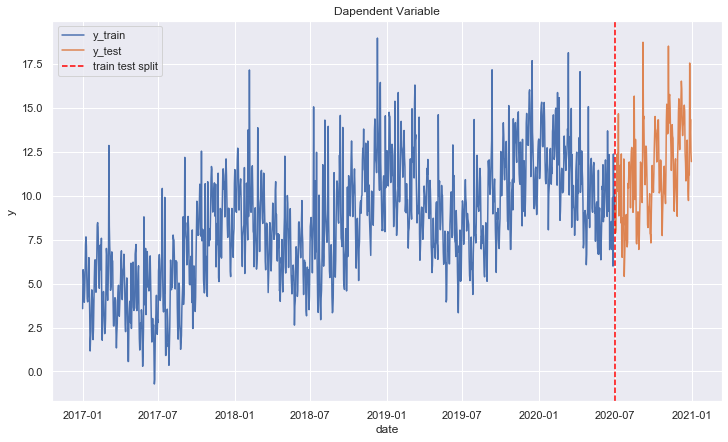

In [10]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y='y', label='y_train', data=df_train, ax=ax)
sns.lineplot(x='date', y='y', label='y_test', data=df_test, ax=ax)
ax.axvline(threshold_date, color='red', linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dapendent Variable');

## Time Series Analysis

We are going to assume we do not know how the data was generate and show some techniques to recover the seasonality and the effect of the `x` variable.

**Warning:** We just use the training data in this step so that we do not leak information from the test set. 

### Smoothing

Let us use a `gaussian_filter` and visualize various levels of smoothness.

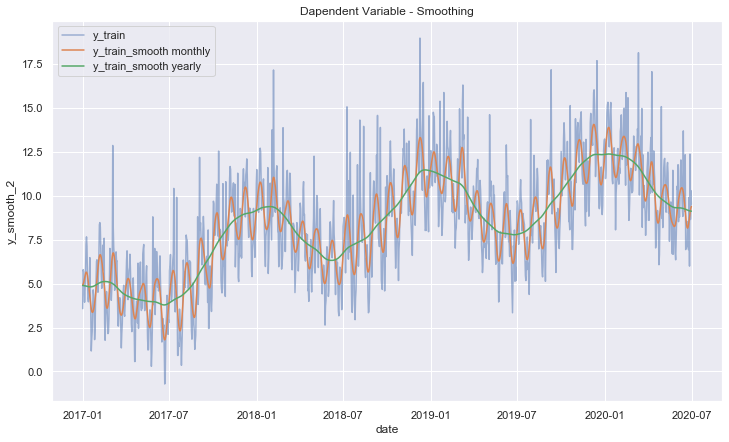

In [11]:
from scipy.ndimage import gaussian_filter

df_smooth = df_train \
    .assign(y_smooth_1 = lambda x: gaussian_filter(input=x['y'], sigma=3.5)) \
    .assign(y_smooth_2 = lambda x: gaussian_filter(input=x['y'], sigma=15)) \

fig, ax = plt.subplots()
sns.lineplot(x='date', y='y', label='y_train', data=df_smooth, alpha=0.5, ax=ax)
sns.lineplot(x='date', y='y_smooth_1', label='y_train_smooth monthly', data=df_smooth, ax=ax)
sns.lineplot(x='date', y='y_smooth_2', label='y_train_smooth yearly', data=df_smooth, ax=ax)
ax.legend(loc='upper left')
ax.set(title='Dapendent Variable - Smoothing');

From this plot we indeed see two clear seasonalities: yearly and monthly. Moreover, let us plot the mean of `y` over the day of the month. 

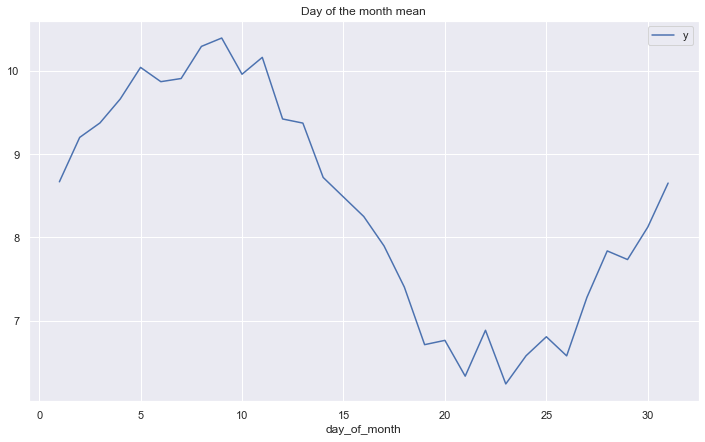

In [12]:
fig, ax = plt.subplots()
df_train.groupby('day_of_month').agg({'y': np.mean}).plot(ax=ax)
ax.set(title='Day of the month mean');

### Remove yearly and monthly seasonality

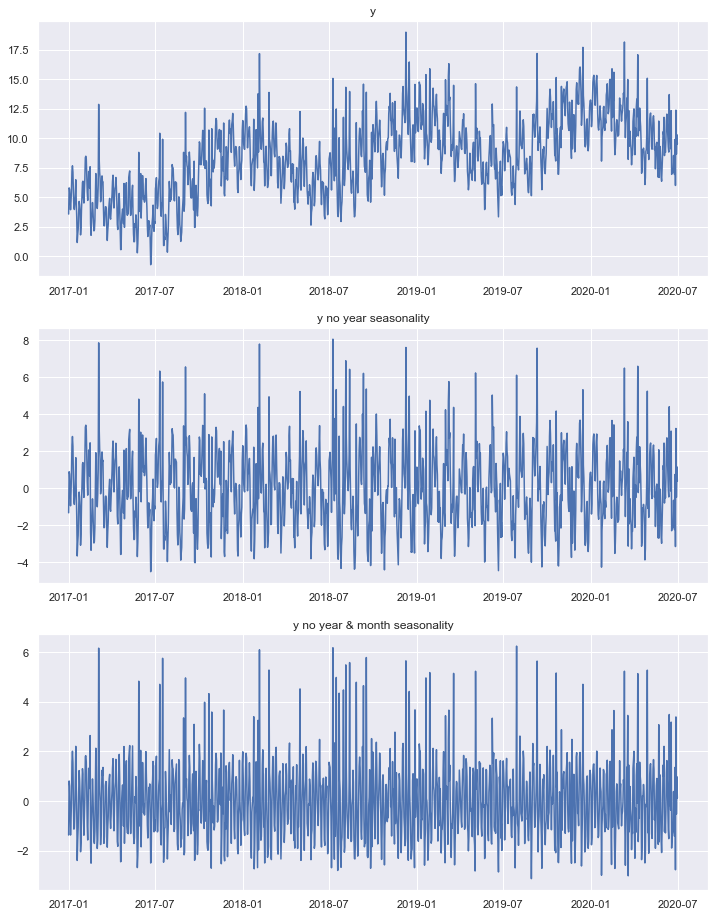

In [13]:
# Remove yearly seasonality.
y_no_year_season = df_smooth['y'] - df_smooth['y_smooth_2']
# Remove monthly seasonality.
y_no_year_month_season = y_no_year_season - gaussian_filter(input=y_no_year_season, sigma=3.5)

fig, ax = plt.subplots(3, 1, figsize=(12, 16))
ax[0].plot(df_smooth['date'], df_smooth['y'])
ax[0].set(title='y')
ax[1].plot(df_smooth['date'], y_no_year_season)
ax[1].set(title='y no year seasonality')
ax[2].plot(df_smooth['date'], y_no_year_month_season)
ax[2].set(title='y no year & month seasonality');

### AC and PAC

Let us now compute the auto correlation and partial-autocorrelation.

- Autocorrelation

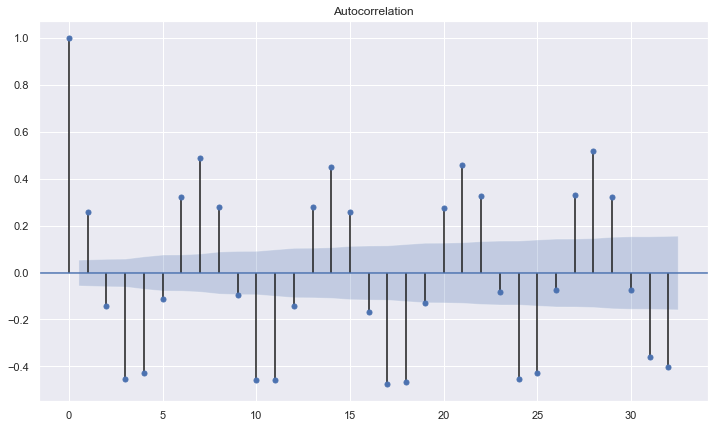

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots()
plot_acf(x=y_no_year_month_season, ax=ax);

- Partial Autocorrelation

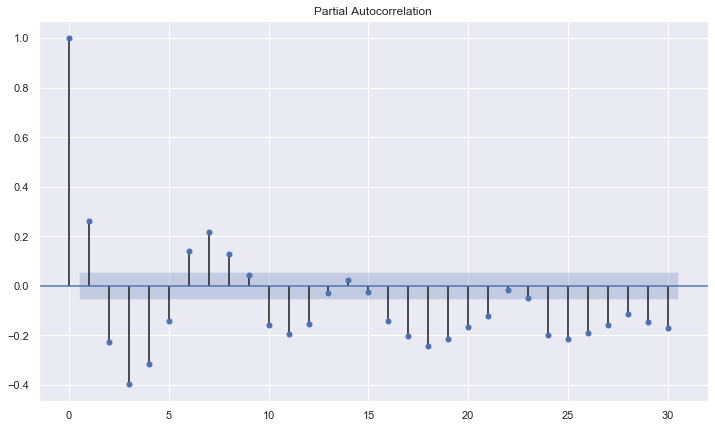

In [15]:
fig, ax = plt.subplots()
plot_pacf(x=y_no_year_month_season, ax=ax, lags=30);

### Periodogram

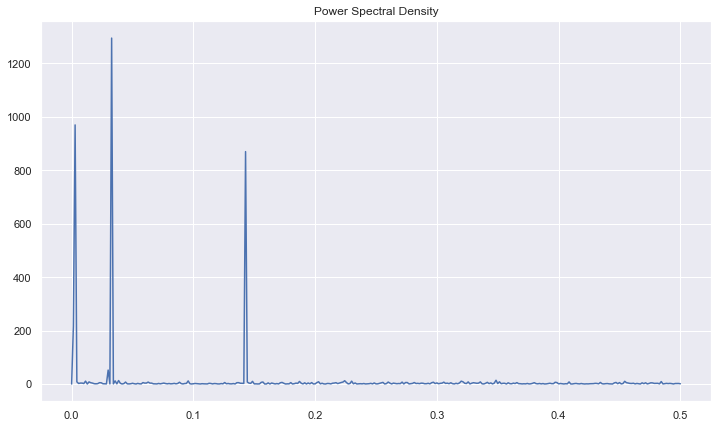

In [16]:
from scipy import signal

f, Pxx_den = signal.periodogram(x=df_train['y'], detrend='linear', nfft=int(7e2))

fig, ax = plt.subplots()
sns.lineplot(x=f, y=Pxx_den, ax=ax)
ax.set(title='Power Spectral Density');

In [17]:
sort_freq_index = np.argsort(a=Pxx_den)[::-1]

periodogram_df = pd.DataFrame(
    {'sort_freq': f[sort_freq_index], 'Pxx_den': Pxx_den[sort_freq_index]}
)

periodogram_df.assign(days = lambda x: 1/x['sort_freq']).head(5)

,sort_freq,Pxx_den,days
0,0.032857,1294.338867,30.434783
1,0.002857,969.437927,350.000000
2,0.142857,869.559082,7.000000
3,0.001429,216.248459,700.000000
4,0.030000,52.113163,33.333333


### Correlations

We want to compute the correlatio of y (no yearly-monthlz seasonality) with x and its lags. 

In [18]:
np.corrcoef(df_train['y'], df_train['x'])[0, 1]

0.33077653194120743

In [19]:
np.corrcoef(y_no_year_month_season, df_train['x'])[0, 1]

0.597197436907567

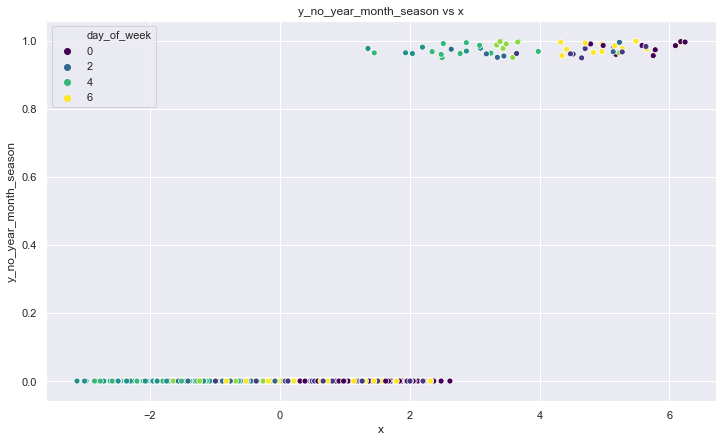

In [20]:
fig, ax = plt.subplots()
sns.scatterplot(
    x=y_no_year_month_season, 
    y=df_train['x'], 
    hue=df['day_of_week'],
    palette='viridis',
    ax=ax, 
)

ax.set(
    title='y_no_year_month_season vs x', 
    xlabel='x', 
    ylabel='y_no_year_month_season'
);

In [21]:
dow_df = df_train[['day_of_week']].copy()
dow_df['y_no_year_month_season'] = y_no_year_month_season
dow_dummies =pd.get_dummies(dow_df['day_of_week'])
dow_dummies.columns = ['d' + str(i) for i in dow_dummies.columns]
dow_df_df = pd.concat([dow_df, dow_dummies], axis=1)
dow_df_df.head()

,day_of_week,y_no_year_month_season,d0,d1,d2,d3,d4,d5,d6
0,6,-1.367378,0,0,0,0,0,0,1
1,0,0.809716,1,0,0,0,0,0,0
2,1,0.605723,0,1,0,0,0,0,0
3,2,-0.352346,0,0,1,0,0,0,0
4,3,-1.366961,0,0,0,1,0,0,0


In [22]:
import statsmodels.formula.api as smf

mod = smf.ols(
    formula='y_no_year_month_season ~ d0 + d1 + d2 + d3 + d4 + d5 + d6', 
    data=dow_df_df
)

res = mod.fit()

print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     y_no_year_month_season   R-squared:                       0.482
Model:                                OLS   Adj. R-squared:                  0.480
Method:                     Least Squares   F-statistic:                     197.3
Date:                    Sat, 08 Feb 2020   Prob (F-statistic):          1.19e-177
Time:                            12:57:53   Log-Likelihood:                -1946.2
No. Observations:                    1277   AIC:                             3906.
Df Residuals:                        1270   BIC:                             3943.
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [23]:
np.corrcoef(res.resid, df_train['x'])[0, 1]

0.8145977167423999

## Define Model

In [24]:
# Local linear trend. 
local_linear_trend = tfp.sts.LocalLinearTrend(
    observed_time_series=df_train['y'], 
    name='local_linear_trend',
)

num_days_per_month = np.array(
  [[31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
   [31, 29, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31]] # year with leap day.\
)  

month_of_year = tfp.sts.Seasonal(
  num_seasons=12,
  num_steps_per_season=num_days_per_month,
  name='month_of_year'
)

day_of_week = tfp.sts.Seasonal(
    num_seasons=7, 
    num_steps_per_season=1,
    observed_time_series=df_train['y'], 
    name='day_of_week',
)

design_matrix_day_of_month = tf.reshape(
    np.sin(2*np.pi*df['day_of_month'] / df['daysinmonth']).values.astype(np.float32), 
    (-1, 1)
)

day_of_month = tfp.sts.LinearRegression(
    design_matrix=design_matrix_day_of_month,
    name='day_of_month'
)

design_matrix_x_var = tf.reshape(df['x'].values.astype(np.float32), (-1, 1))

x_var = tfp.sts.LinearRegression(
    design_matrix=design_matrix_x_var,
    name='x_var'
)


model_components = [
    local_linear_trend, 
    month_of_year, 
    day_of_week, 
    day_of_month, 
    x_var,
]

toy_model = tfp.sts.Sum(
    components=model_components, 
    observed_time_series=df_train['y']
)

Instructions for updating:
Do not call `graph_parents`.


## Model Fit

In [25]:
# Build the variational surrogate posteriors `qs`.
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=toy_model)

Instructions for updating:
SeedStream has moved to `tfp.util.SeedStream`.


In [26]:
#@title Minimize the variational loss.

# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 200 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=0.1)
# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=toy_model.joint_log_prob(
            observed_time_series=df_train['y']),
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_variational_steps,
        seed=42
    )
    return elbo_loss_curve

elbo_loss_curve = train()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


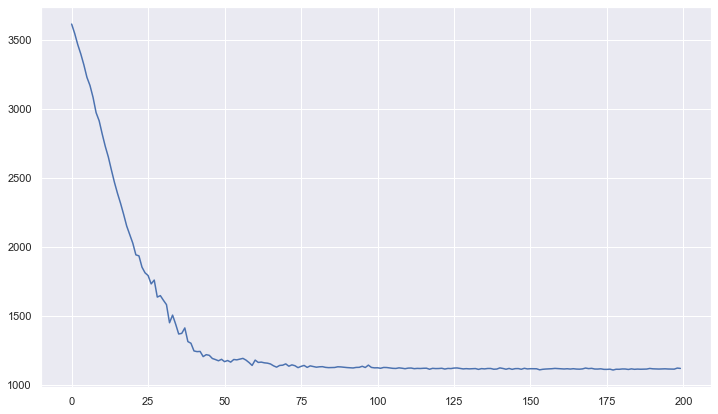

In [27]:
fig, ax = plt.subplots()
ax.plot(elbo_loss_curve)

In [28]:
q_samples = variational_posteriors.sample(50)

In [29]:
print('Inferred parameters:')
for param in toy_model.parameters:
    print("{}: {} +- {}".format(
        param.name,
        np.mean(q_samples[param.name], axis=0),
        np.std(q_samples[param.name], axis=0))
    )

Inferred parameters:
observation_noise_scale: 0.5277767777442932 +- 0.008411722257733345
local_linear_trend/_level_scale: 0.014802204445004463 +- 0.007012656889855862
local_linear_trend/_slope_scale: 0.0006277618813328445 +- 0.00017276880680583417
month_of_year/_drift_scale: 0.006905738729983568 +- 0.016429074108600616
day_of_week/_drift_scale: 0.005730484612286091 +- 0.004968337714672089
day_of_month/_weights: [1.9403486] +- [0.01833247]
x_var/_weights: [4.940448] +- [0.06913605]


In [30]:
forecast_window = num_days_per_month[-1][6:13].sum()

forecast_dist = tfp.sts.forecast(
    toy_model,
    observed_time_series=df_train['y'],
    parameter_samples=q_samples,
    num_steps_forecast=forecast_window 
)

## Model Predictions

In [31]:
num_days_per_month[1][6:13].sum()

184

In [32]:
num_samples=100

forecast_mean, forecast_scale, forecast_samples = (
    forecast_dist.mean().numpy().flatten(),
    forecast_dist.stddev().numpy().flatten(),
    forecast_dist.sample(num_samples).numpy().flatten()
)

In [33]:
df_test['y_pred'] = forecast_mean.copy()
df_test['y_pred_std'] = forecast_scale.copy()
df_test['errors'] = df_test['y'] - df_test['y_pred']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

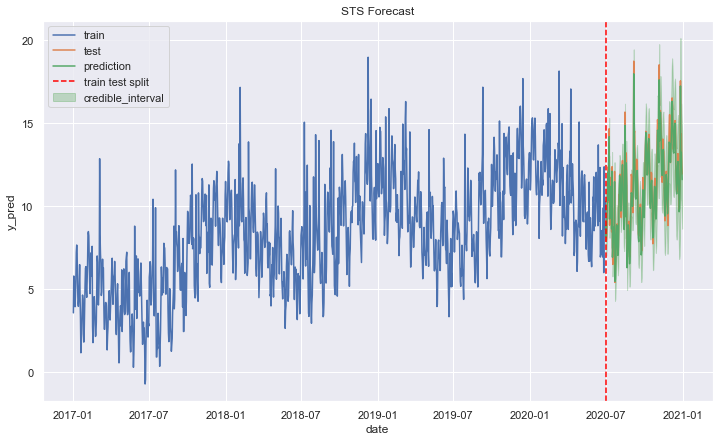

In [34]:
fig, ax = plt.subplots()

ax.fill_between(
    x=df_test['date'],
    y1=df_test['y_pred']-2*df_test['y_pred_std'],
    y2=df_test['y_pred']+2*df_test['y_pred_std'],
    color='green', 
    alpha=0.2,
    label='credible_interval'
)

sns.lineplot(x='date', y='y', label='train', data=df_train, ax=ax)
sns.lineplot(x='date', y='y', label='test', data=df_test, ax=ax)
sns.lineplot(x='date', y='y_pred', label='prediction', data=df_test, ax=ax)

ax.axvline(pd.to_datetime(threshold_date), color='red', linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='STS Forecast');

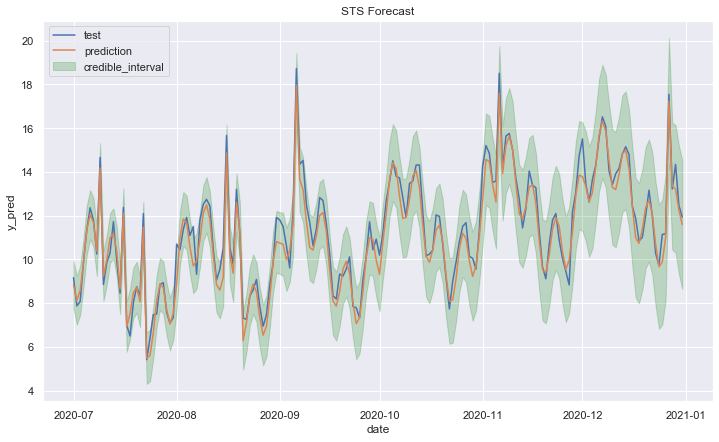

In [35]:
fig, ax = plt.subplots()

ax.fill_between(
    x=df_test['date'],
    y1=df_test['y_pred']-2*df_test['y_pred_std'],
    y2=df_test['y_pred']+2*df_test['y_pred_std'],
    color='green', 
    alpha=0.2,
    label='credible_interval'
)
sns.lineplot(x='date', y='y', label='test', data=df_test, ax=ax)
sns.lineplot(x='date', y='y_pred', label='prediction', data=df_test, ax=ax)
ax.legend(loc='upper left')
ax.set(title='STS Forecast');

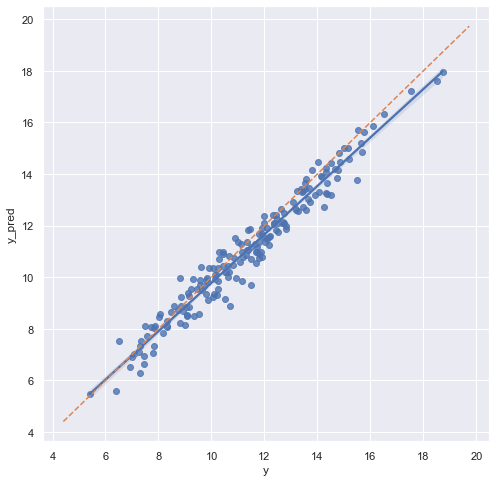

In [36]:
fig, ax = plt.subplots(figsize=(8,8))

d_x = np.linspace(start=df_test['y'].min() - 1, stop=df_test['y'].max() + 1, num=100)

sns.regplot(x='y', y='y_pred', data=df_test, ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, ax=ax)
ax.lines[1].set_linestyle('--')

- Errors

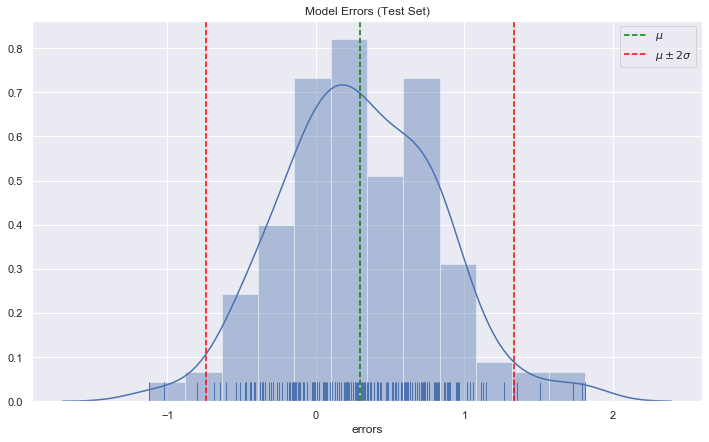

In [37]:
fig, ax = plt.subplots()
sns.distplot(a=df_test['errors'], ax=ax, rug=True)
ax.axvline(df_test['errors'].mean(), color='green', linestyle='--', label=r'$\mu$ ')
ax.axvline(df_test['errors'].mean() + 2*df_test['errors'].std(), color='red', linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axvline(df_test['errors'].mean() - 2*df_test['errors'].std(), color='red', linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

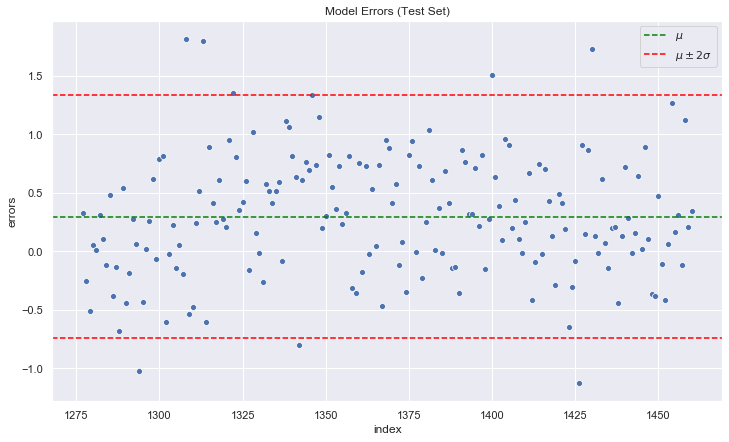

In [38]:
fig, ax = plt.subplots()
sns.scatterplot(x='index', y='errors', data=df_test.reset_index(), ax=ax)
ax.axhline(df_test['errors'].mean(), color='green', linestyle='--', label=r'$\mu$ ')
ax.axhline(df_test['errors'].mean() + 2*df_test['errors'].std(), color='red', linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axhline(df_test['errors'].mean() - 2*df_test['errors'].std(), color='red', linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

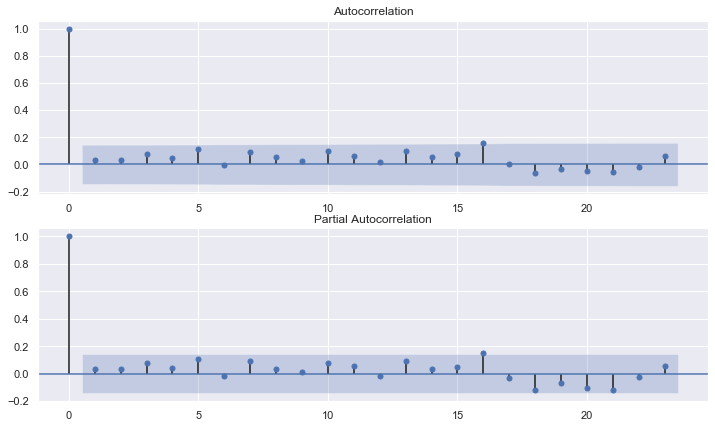

In [39]:
fig, ax = plt.subplots(2, 1)
plot_acf(x=df_test['errors'], ax=ax[0])
plot_pacf(x=df_test['errors'], ax=ax[1]);

## Decomposition

In [40]:
component_dists = tfp.sts.decompose_by_component(
    model=toy_model,
    observed_time_series=df_train['y'],
    parameter_samples=q_samples
)

In [41]:
component_means, component_stddevs = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

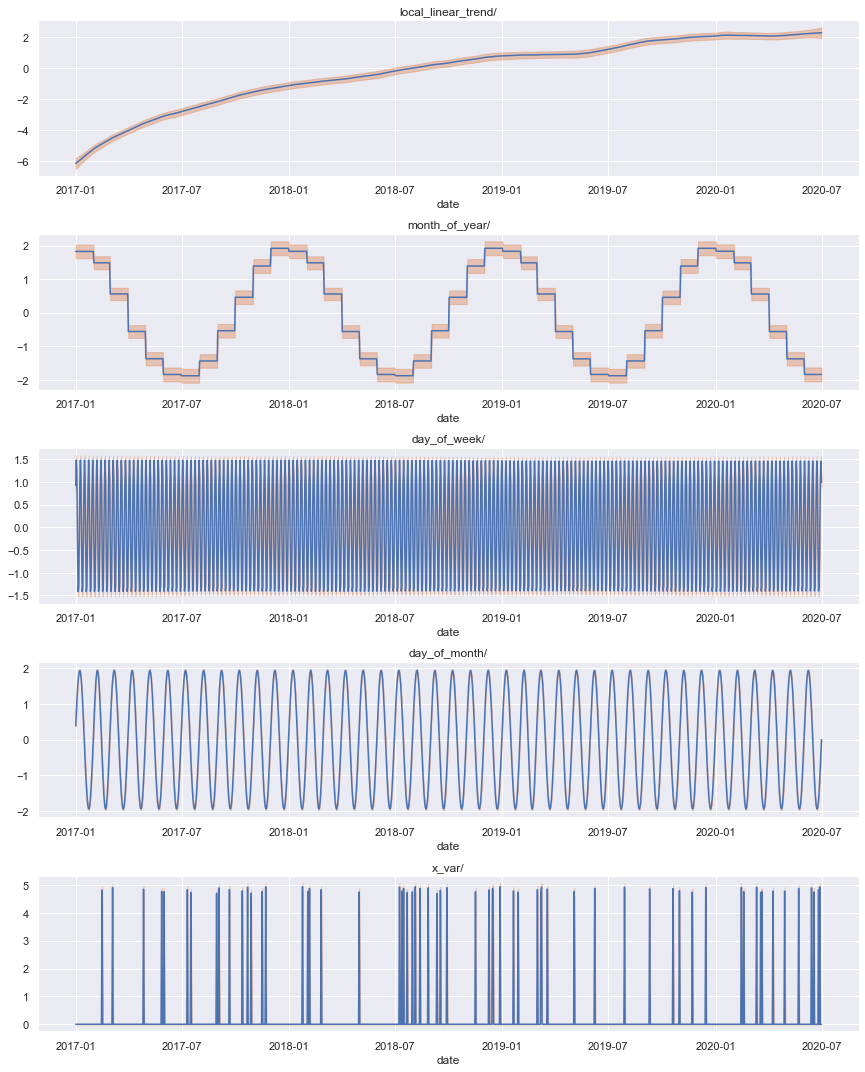

In [42]:
num_components = len(component_means)

colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig, ax = plt.subplots(num_components, 1, figsize= (12, 15))

for i, component_name in enumerate(component_means.keys()):
    component_mean = component_means[component_name]
    component_stddev = component_stddevs[component_name]
    
    sns.lineplot(x=df_train['date'], y=component_mean, color=c1, ax=ax[i])
    
    ax[i].fill_between(
        x=df_train['date'],
        y1=component_mean-2*component_stddev,
        y2=component_mean+2*component_stddev,
        alpha=0.4, 
        color=c2
    )
    
    ax[i].set(title=component_name)

plt.tight_layout()